start_time_sec -> inclusive  
end_time_sec -> inclusive

In [10]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import sys

In [24]:
def aggregate_data(min_bins_start,df):
    i = 1
    j = 1
    v = []
    for var in range(len(min_bins_start)-1):
        a = min_bins_start[var]
        b = min_bins_start[var+1]
        # i points to the scoot bin immediately before interested time period
        while df['seconds'][i] < a: 
            i = i + 1
        i = i - 1
        # j points to the scoot bin immediately after interested time period
        while df['seconds'][j] < b and j!=len(df)-1:
            j = j + 1
        if j - i == 1: # [i,a,b,j]
            v.append(df['Volume'][i]/df['CycleTime'][i]*(b-a))
        elif j - i == 2: # [i,a,i+1(j-1),b,j]
            v.append(df['Volume'][i]*((df['seconds'][i+1]-a)/df['CycleTime'][i])+df['Volume'][j-1]*((b-df['seconds'][j-1])/df['CycleTime'][j-1]))
        else:   # [i,a,i+1,i+2,...,j-1,b,j]
            vt = 0
            for k in range(j-1-(i+1)):
                vt = vt + df['Volume'][i+k+1]
            v.append(vt+df['Volume'][i]*((df['seconds'][i+1]-a)/df['CycleTime'][i])+df['Volume'][j-1]*((b-df['seconds'][j-1])/df['CycleTime'][j-1]))
    return v


In [177]:
# Lakeshore from Bathurst to Stadium
tcl = 1147201
sdetectors = ['N30421B1']#,'30421B2'] # close to bathurst
rloop = 'DW0060DWL' # close to stadium
sdate = '20170215'
rdate = '15-FEB-2017'

In [178]:
# Read in Rescu Data
rescu = pd.read_csv('Stn_20SecData_'+rdate+'.csv', header=0, names=['Time','VDS_id','Ln','Volume','Occ','Speed'])
# Filter for loop
rescu = rescu[rescu['VDS_id']==rloop]
# Time Filter
rescu['Time'] = pd.to_datetime(rescu['Time'])
rescu['seconds'] = (rescu['Time'] - pd.to_datetime(sdate)).dt.total_seconds().astype(int)
rescu['CycleTime'] = 20
# (Optional) Filter if looking at specific lane
rescu = rescu[rescu['Ln']==3]

# Read in Scoot Data
scoot = pd.DataFrame()
for hour in range(0, 24):
    if hour<10:
        h = '0'+str(hour)
    else:
        h = str(hour)
    s = pd.read_table("C:/Users/qwang2/Documents/7 SCOOT/Disaggregate Data Validation/"+sdate+" RAW/M29_"+sdate+"H"+h+"R02.txt",delim_whitespace=True,error_bad_lines=False,skiprows=1,header=None, 
                      names=['Date','Time','M29','detector','CycleTime','Volume','Unknown'])
    scoot = pd.concat([scoot,s])                     
# Filter for detectors
scoot = scoot[(scoot['detector'].isin(sdetectors))]
# Sum detector observations if looking at approach with multiple detectors
scoot['Volume'] = scoot['Volume'].astype(int)
#scoot = scoot.groupby(['Date','Time','CycleTime'],as_index=False).sum()
scoot['seconds'] = (pd.to_datetime(scoot['Date']+' '+scoot['Time'])-pd.to_datetime(sdate)).dt.total_seconds().astype(int)
# Sort based on Time (Data is sorted most of the time, occasional mess)
scoot = scoot.sort_values(['seconds'])

Bins = SCOOT Cycles, Rescu Offset = -15 sec


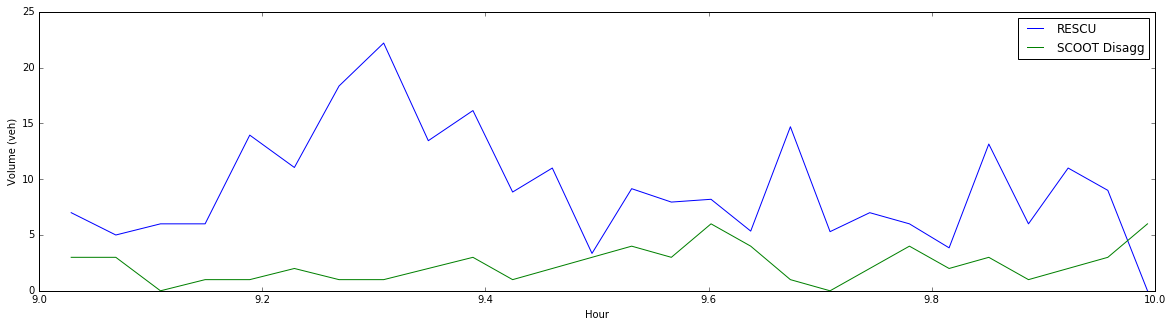

In [179]:
start_hour = 9
start_min = 0
start_sec = 0
end_hour = 10
end_min = 0
end_sec = 0
offset = -15
plt.subplots(figsize=[20,5]) 

print('Bins = SCOOT Cycles, Rescu Offset =', offset, 'sec')
start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec

# Time Filter
s = scoot[(scoot['seconds']>=start_time_sec) & (scoot['seconds']<=end_time_sec)].copy()
r = rescu[(rescu['seconds']>=start_time_sec) & (rescu['seconds']<=end_time_sec)].copy()

# Offset Rescu 
r['seconds']=r['seconds']+offset

# Reset Index
s.reset_index(inplace=True,drop=True)
r.reset_index(inplace=True,drop=True)

min_bins_start = list(s['seconds'])
min_bins_start.append(s['seconds'].values[-1]+s['CycleTime'].values[-1])

v = aggregate_data(min_bins_start,r)

plt.plot([x/3600 for x in min_bins_start[:-1]],v,label='RESCU')
plt.plot([x/3600 for x in min_bins_start[:-1]],s['Volume'],label='SCOOT Disagg')
plt.legend()
plt.ylabel('Volume (veh)')
plt.xlabel('Hour')
plt.show()

binsize = 60 seconds, Rescu Offset = -15 sec


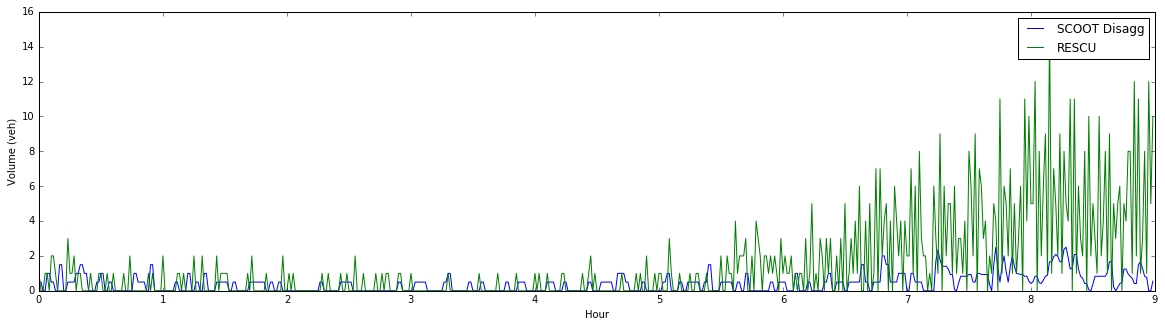

binsize = 120 seconds, Rescu Offset = -15 sec


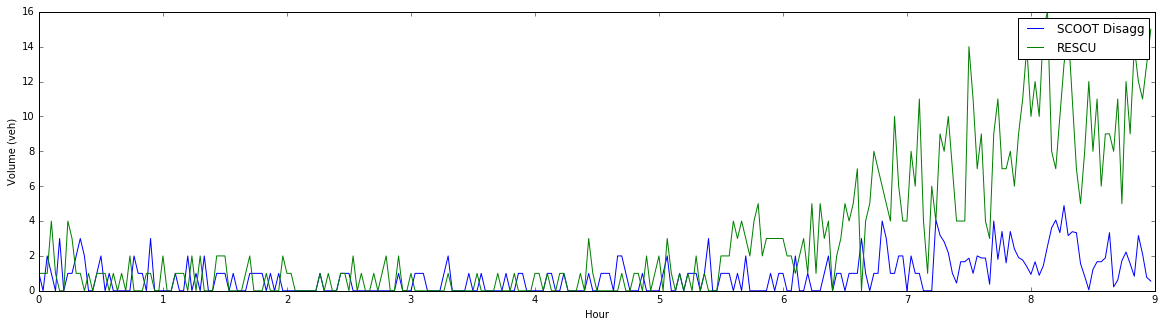

binsize = 180 seconds, Rescu Offset = -15 sec


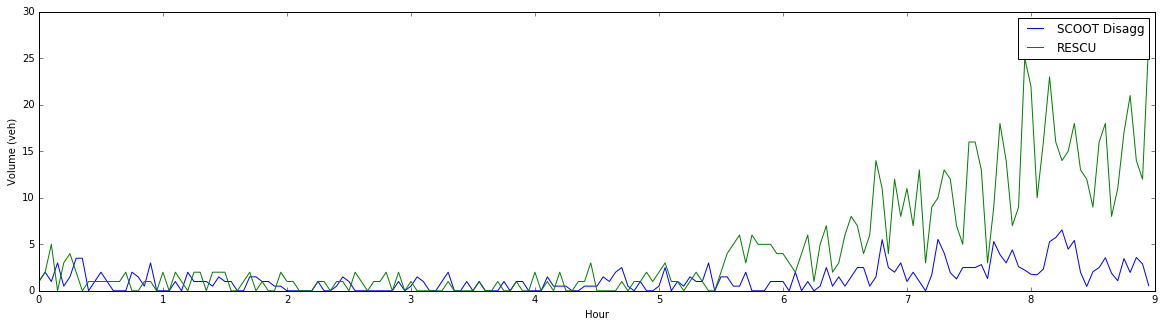

binsize = 300 seconds, Rescu Offset = -15 sec


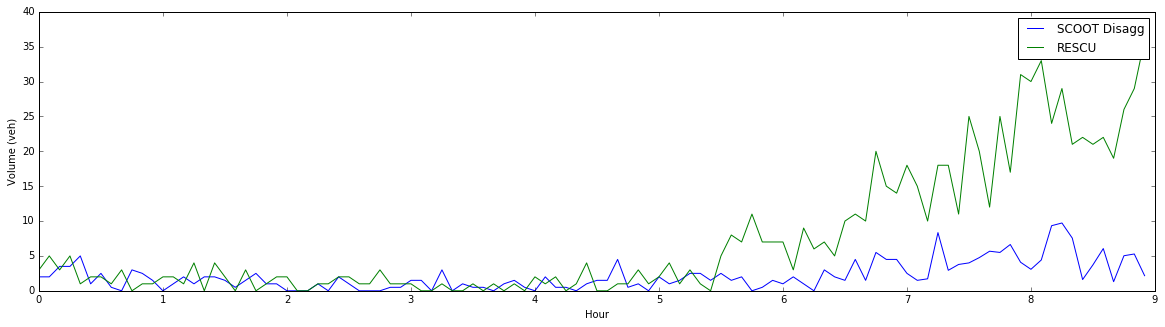

In [89]:
bin_sec_s=[60, 120, 180, 300]
start_hour = 0
start_min = 0
start_sec = 0
end_hour = 9
end_min = 0
end_sec = 0
offset = -15

start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec
s = scoot.copy()
s.reset_index(inplace=True,drop=True)

for bin_sec in bin_sec_s:
    print('binsize =', bin_sec , 'seconds, Rescu Offset =', offset, 'sec')
    plt.subplots(figsize=(20,5))
    
    num_bins = (end_time_sec - start_time_sec)//bin_sec
    min_bins_start = list(np.linspace(start_time_sec, start_time_sec+bin_sec*num_bins, num_bins+1))
    r = rescu.copy()
    # Offset Rescu 
    r['seconds']=r['seconds']+offset
    # Create bin index
    r['bin'] = r['seconds']//bin_sec

    # Sum 20sec observations to desired bin size, also summing lanes if lane filter not activated
    r = r.groupby(['VDS_id','bin'],as_index=False).sum()
    r['seconds'] = r['bin']*bin_sec
    r = r[(r['seconds']>=start_time_sec) & (r['seconds']<=(end_time_sec-bin_sec))]
    v = aggregate_data(min_bins_start,s)
    
    plt.plot([x/3600 for x in min_bins_start[:-1]],v,label='SCOOT Disagg')
    plt.plot([x/3600 for x in min_bins_start[:-1]],r['Volume'],label='RESCU')
    plt.ylabel('Volume (veh)')
    plt.xlabel('Hour')
    plt.legend()
    plt.show()